# Time Series Analysis with ARMA Models

This notebook demonstrates a comprehensive approach to time series analysis using Apple stock data. The workflow covers:

- **Data acquisition and exploration**: Fetching historical stock prices and understanding their distributions
- **Stationarity testing**: Applying statistical tests (ADF, KPSS, Jarque-Bera) to assess time series properties
- **Data transformation**: Converting price levels to log returns for stationarity
- **Autocorrelation analysis**: Examining temporal dependencies through ACF and PACF plots

The analysis follows best practices in financial time series modeling, including proper stationarity testing before model fitting and the use of log returns to handle non-stationary price data.

In [ ]:
# --- Required Libraries ---
# Core data manipulation and numerical computing
import numpy as np
import pandas as pd
from scipy import stats

# Financial data retrieval
import yfinance as yf

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis and statistical testing
import statsmodels.graphics.tsaplots
import statsmodels.tsa
import statsmodels.stats.stattools
import statsmodels.stats.diagnostic
from scipy.optimize import brute
from statsmodels.tsa.arima.model import ARIMA

## Loading the data and initial exploration

In [4]:
# Fetching historical data for Apple stock (AAPL) over the past 10 years
# This provides a comprehensive dataset for analyzing long-term trends and patterns
apple_tick = yf.Ticker("AAPL")
apple_history = apple_tick.history(period = "10y")

In [5]:
# Quick overview of the dataset structure
# Displaying first and last 5 rows to check data consistency and time range
pd.concat([apple_history.head(5), apple_history.tail(5)])

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-09 00:00:00-05:00,27.299160,27.490994,27.093785,27.211142,135485600,0.0,0.0
2015-11-10 00:00:00-05:00,26.382871,26.646925,26.193293,26.353531,236511600,0.0,0.0
2015-11-11 00:00:00-05:00,26.263254,26.500225,26.001455,26.204575,180872000,0.0,0.0
2015-11-12 00:00:00-05:00,26.238428,26.364812,26.100758,26.116556,130102400,0.0,0.0
2015-11-13 00:00:00-05:00,25.999197,26.082702,25.337933,25.353731,183249600,0.0,0.0
2025-11-03 00:00:00-05:00,270.420013,270.850006,266.250000,269.049988,50194600,0.0,0.0
2025-11-04 00:00:00-05:00,268.329987,271.489990,267.619995,270.040009,49274800,0.0,0.0
2025-11-05 00:00:00-05:00,268.609985,271.700012,266.929993,270.140015,43683100,0.0,0.0
2025-11-06 00:00:00-05:00,267.890015,273.399994,267.890015,269.769989,51204000,0.0,0.0


## EDA: Exploratory data analysis

In [6]:
# Comprehensive dataset summary including data types, missing values, and descriptive statistics
# Info provides structural details while describe offers statistical measures
print(apple_history.info())
apple_history.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-11-09 00:00:00-05:00 to 2025-11-07 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2515 non-null   float64
 1   High          2515 non-null   float64
 2   Low           2515 non-null   float64
 3   Close         2515 non-null   float64
 4   Volume        2515 non-null   int64  
 5   Dividends     2515 non-null   float64
 6   Stock Splits  2515 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.2 KB
None


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03,2515.000000,2515.000000
mean,110.692396,111.900766,109.578844,110.797730,1.034657e+08,0.003153,0.001590
std,71.489195,72.251908,70.789478,71.564530,5.833927e+07,0.025562,0.079761
min,20.546440,20.927690,20.425432,20.624046,2.323470e+07,0.000000,0.000000
25%,40.900375,41.157093,40.602605,40.873606,6.375580e+07,0.000000,0.000000
50%,116.557244,117.892162,114.926608,116.333138,9.015280e+07,0.000000,0.000000
75%,169.827707,171.620903,168.640285,170.159622,1.268328e+08,0.000000,0.000000
max,276.989990,277.320007,269.160004,271.399994,5.334788e+08,0.260000,4.000000


C:\Users\ncesc\AppData\Local\Temp\ipykernel_14048\3009856028.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  apple_history.hist(ax=ax)


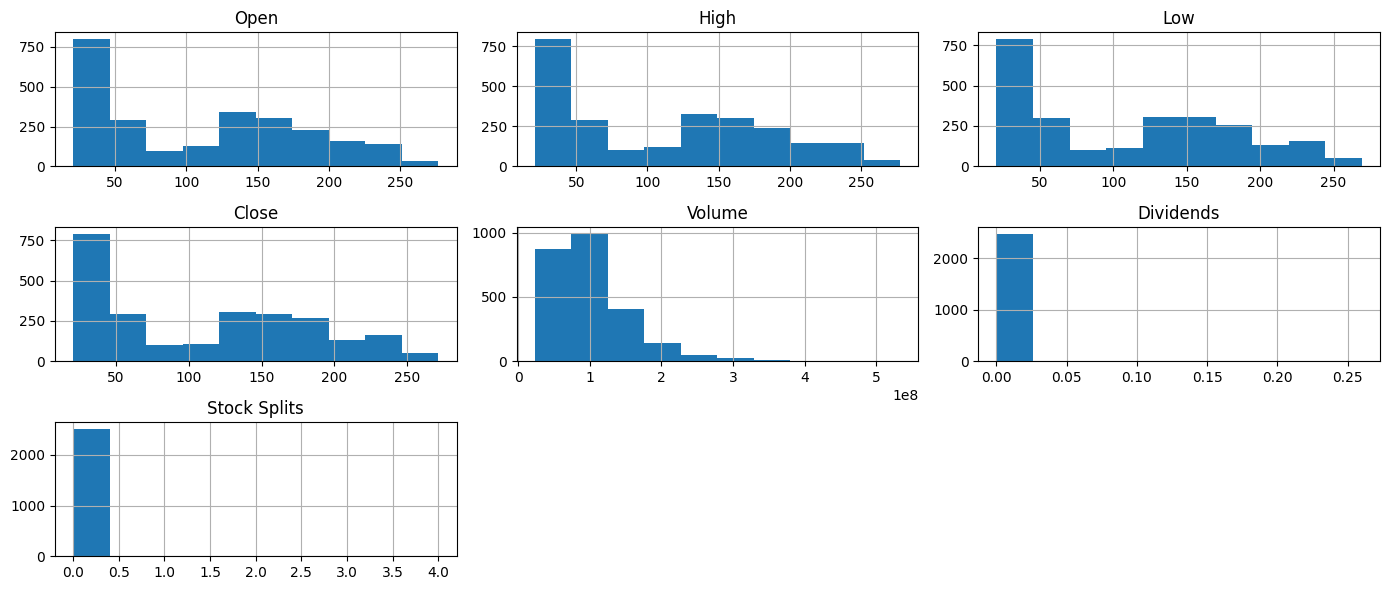

In [7]:
# Visualizing the distributions of all numerical variables in the dataset
# Histograms help identify skewness, outliers, and the overall shape of each variable's distribution
fig, ax = plt.subplots(figsize = (14, 6))
apple_history.hist(ax=ax)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Closing price')

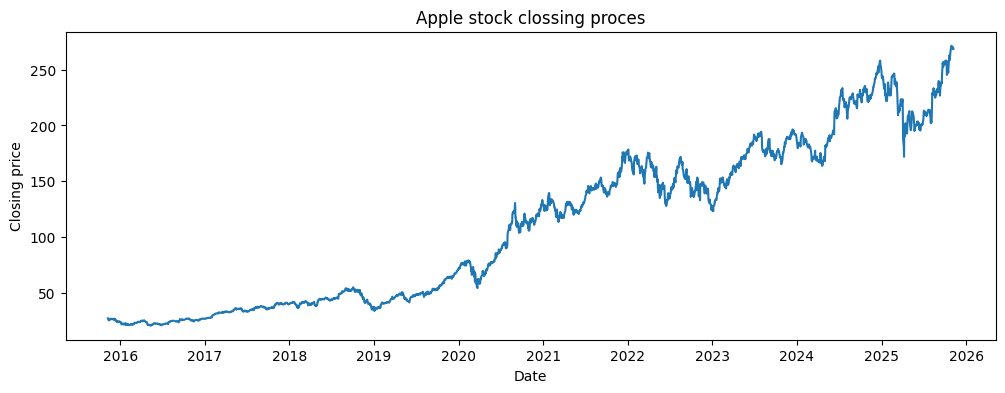

In [8]:
# Time series visualization of daily closing prices
# This plot reveals trends, seasonality, and potential structural breaks in the price series
appl_closing = apple_history[['Close']]

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(appl_closing)
plt.title("Apple stock clossing proces")
plt.xlabel("Date")
plt.ylabel("Closing price")

### Testing for stationarity

In [9]:
# --- Custom functions for enhanced output readability ---
# These wrapper functions format statistical test results into easy-to-read pandas Series

# Augmented Dickey-Fuller (ADF) test for unit root detection
# Tests the null hypothesis that a unit root is present (series is non-stationary)
# Low p-values (<0.05) suggest rejecting the null, indicating stationarity
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value ({})".format(key)] = value
    print(dfoutput)

# KPSS test for stationarity
# Tests the null hypothesis that the series is stationary around a trend
# High p-values (>0.05) suggest failing to reject the null, indicating stationarity
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used"
        ],
    )
    for key, value in dftest[3].items():
        dfoutput["Critical Value ({})".format(key)] = value
    print(dfoutput)

# Jarque-Bera test for normality
# Tests the null hypothesis that data follows a normal distribution
# Evaluates skewness and kurtosis to detect departures from normality
def jarque_bera(timeseries):
    print("Results of Jarque-Bera Test:")
    dftest = statsmodels.stats.stattools.jarque_bera(timeseries)
    dfoutput = pd.Series(
        dftest[:],
        index=[
            "Test Statistic",
            "p-value",
            "Skewness",
            "Kurtosis"
        ],
    )
    print(dfoutput)

In [10]:
# Non-rejection of the null hypothesis indicates presence of unitary root
# Therefore, the closing price series is non-stationary
adf_test(appl_closing)

Results of Dickey-Fuller Test:
Test Statistic                    0.496676
p-value                           0.984772
#Lags Used                       10.000000
Number of Observations Used    2504.000000
Critical Value (1%)              -3.432964
Critical Value (5%)              -2.862695
Critical Value (10%)             -2.567385
dtype: float64


In [11]:
# Rejection of the null hypothesis of stationarity
# This confirms the series is non-stationary, consistent with ADF test results
kpss_test(appl_closing)

Results of KPSS Test:
Test Statistic            7.920488
p-value                   0.010000
#Lags Used               30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ncesc\AppData\Local\Temp\ipykernel_14048\4148490571.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')


In [12]:
# Rejection of normality - stock prices typically exhibit heavy tails and skewness
jarque_bera(appl_closing)

Results of Jarque-Bera Test:
Test Statistic        [206.16758729097802]
p-value           [1.7032454839602403e-45]
Skewness             [0.29862739232791435]
Kurtosis              [1.7308699303341823]
dtype: object


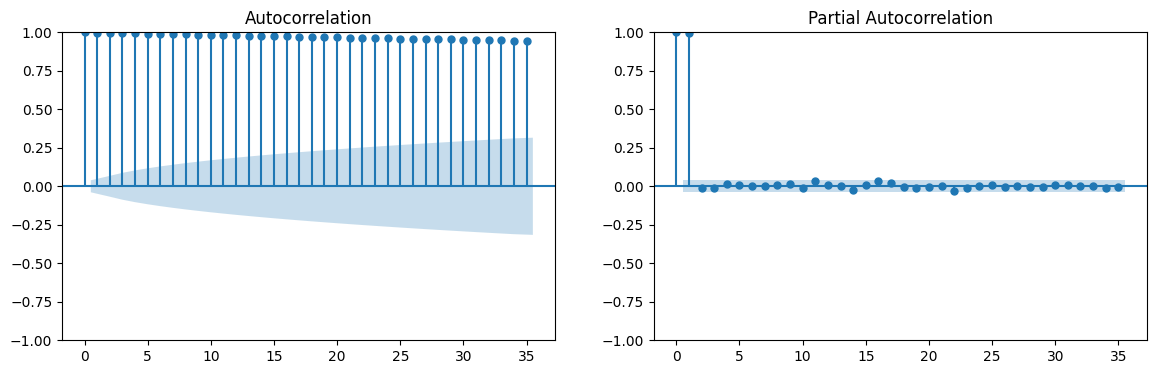

In [13]:
# Autocorrelation and partial autocorrelation analysis for closing prices
# ACF shows correlation of the series with its lagged values
# PACF shows direct correlation at each lag, controlling for shorter lags
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

statsmodels.graphics.tsaplots.plot_acf(appl_closing, ax=ax1)
statsmodels.graphics.tsaplots.plot_pacf(appl_closing, ax=ax2)

plt.show()

### Working with log returns

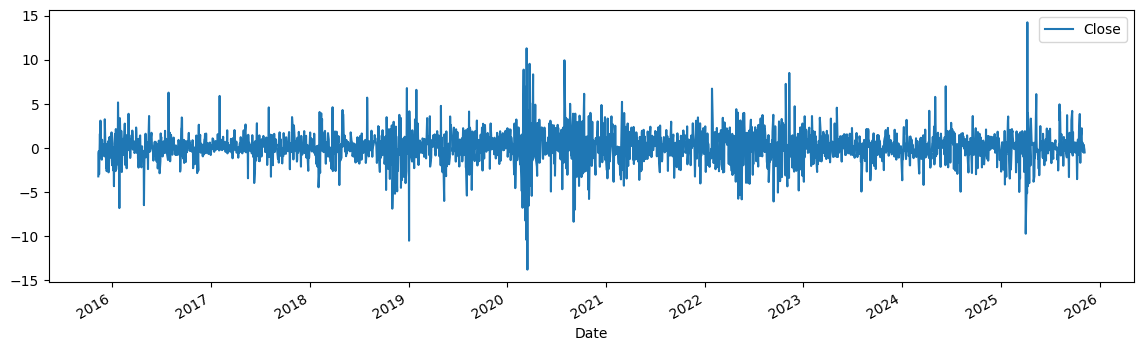

             Close
count  2514.000000
mean      0.091055
std       1.835010
min     -13.770813
25%      -0.734515
50%       0.096974
75%       1.001893
max      14.261749
mode 0.0
skewness -0.08676883739592899
kurtosis 6.567119352608195


In [14]:
# Calculate log returns and multiply by 100 for percentage representation
# Log returns provide stationarity and are more appropriate for financial modeling
# They represent continuously compounded returns between consecutive observations
appl_log_ret = np.log(appl_closing).diff() * 100
appl_log_ret = appl_log_ret.dropna()

# Visualize the log returns time series
# Returns should fluctuate around zero with relatively constant variance
fig, ax = plt.subplots(figsize = (14, 4))
appl_log_ret.plot(ax=ax)
plt.show()

# Display comprehensive statistical summary including higher moments
# Mode, skewness, and kurtosis help assess distribution characteristics
print(appl_log_ret.describe(),
      f'mode {stats.mode(appl_log_ret)[0][0]}',
      f'skewness {stats.skew(appl_log_ret)[0]}',
      f'kurtosis {stats.kurtosis(appl_log_ret)[0]}',
      sep="\n")

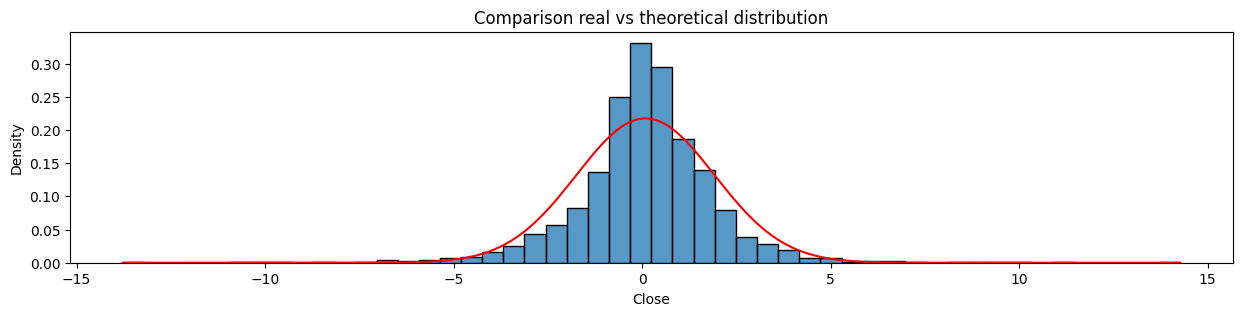

In [15]:
# Visual comparison between empirical distribution and theoretical normal distribution
# Overlaying a fitted normal PDF on the histogram to assess normality assumption
fig, ax = plt.subplots(figsize=(15, 3))
sns.histplot(appl_log_ret['Close'], stat='density', bins=50, kde=False, ax=ax)

# Calculate mean and standard deviation for the fitted normal distribution
mu = appl_log_ret['Close'].mean()
sigma = appl_log_ret['Close'].std()

# Generate probability density function values for the theoretical normal distribution
x = np.linspace(appl_log_ret['Close'].min(), appl_log_ret['Close'].max(), 200)
pdf = stats.norm.pdf(x, mu, sigma)

# Plot the theoretical normal distribution for visual comparison
plt.plot(x, pdf, 'r')
plt.title('Comparison real vs theoretical distribution')
plt.show()

### Retesting now for log returns

In [16]:
# Rejection of the null hypothesis indicates no unit root present
# The log returns series is now stationary, suitable for ARMA modeling
adf_test(appl_log_ret)

Results of Dickey-Fuller Test:
Test Statistic                -1.612799e+01
p-value                        4.819016e-29
#Lags Used                     8.000000e+00
Number of Observations Used    2.505000e+03
Critical Value (1%)           -3.432963e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567385e+00
dtype: float64


In [17]:
# Non-rejection of the null hypothesis confirms stationarity
# Both ADF and KPSS tests now agree that the series is stationary
kpss_test(appl_log_ret)

Results of KPSS Test:
Test Statistic           0.057373
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\ncesc\AppData\Local\Temp\ipykernel_14048\4148490571.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')


In [18]:
# Rejection of normality - log returns still show deviation from normal distribution
# This is common in financial data due to volatility clustering and extreme events
jarque_bera(appl_log_ret)

Results of Jarque-Bera Test:
Test Statistic       [4520.713758198197]
p-value                            [0.0]
Skewness          [-0.08676883739592899]
Kurtosis             [9.567119352608195]
dtype: object


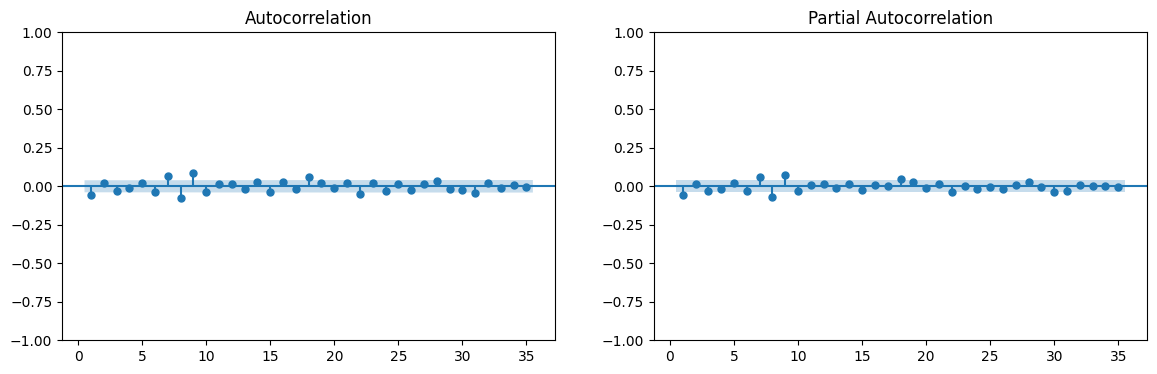

In [19]:
# Autocorrelation and partial autocorrelation analysis for log returns
# ACF and PACF patterns help identify appropriate AR and MA orders for ARMA modeling
# Excluding zero lag provides clearer view of temporal dependencies
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

statsmodels.graphics.tsaplots.plot_acf(appl_log_ret, ax=ax1, zero= False)
statsmodels.graphics.tsaplots.plot_pacf(appl_log_ret, ax=ax2, zero= False)
plt.show()

In [20]:
# Ljung-Box test for autocorrelation across multiple lags
# Rejection of the null hypothesis indicates significant autocorrelation exists
# This confirms that the series has temporal structure worth modeling with ARMA
statsmodels.stats.diagnostic.acorr_ljungbox(appl_log_ret, lags=20)

,lb_stat,lb_pvalue
1,8.028051,4.605837e-03
2,9.027703,1.095618e-02
3,11.369338,9.887528e-03
4,11.807853,1.883881e-02
5,12.856314,2.476312e-02
6,15.865591,1.449387e-02
7,26.994722,3.340097e-04
8,42.778539,9.669303e-07
9,61.024554,8.505350e-10
10,64.904404,4.227591e-10


## Fitting the model

### Performing a manual train-test split

In [21]:
# Determining the timespan
print(appl_log_ret.index.max(),
      appl_log_ret.index.min(),
      appl_log_ret.index.max() - appl_log_ret.index.min(),
      appl_log_ret.shape,
      sep='\n')

# Estimating the partition dates based on a 60-40 split:
train = appl_log_ret.iloc[:int(2514 * 0.6), :]
test = appl_log_ret.iloc[int(2514 * 0.6):, :]

print(train.shape, test.shape)

2025-11-07 00:00:00-05:00
2015-11-10 00:00:00-05:00
3650 days 00:00:00
(2514, 1)
(1508, 1) (1006, 1)


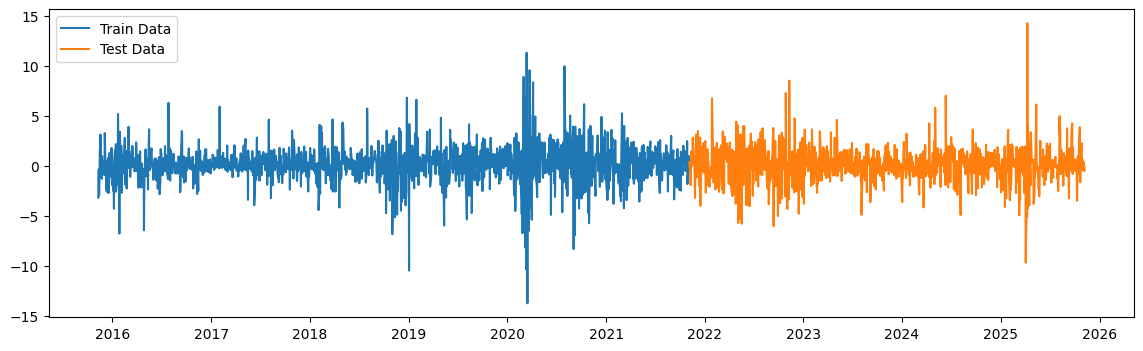

In [22]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train, label='Train Data')
ax.plot(test, label='Test Data')
plt.legend(loc = 'best')
plt.show()

### Training the ARMA model

In [23]:
arima_model = ARIMA(train, order=(1, 0, 1))
arima_fit = arima_model.fit()

c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


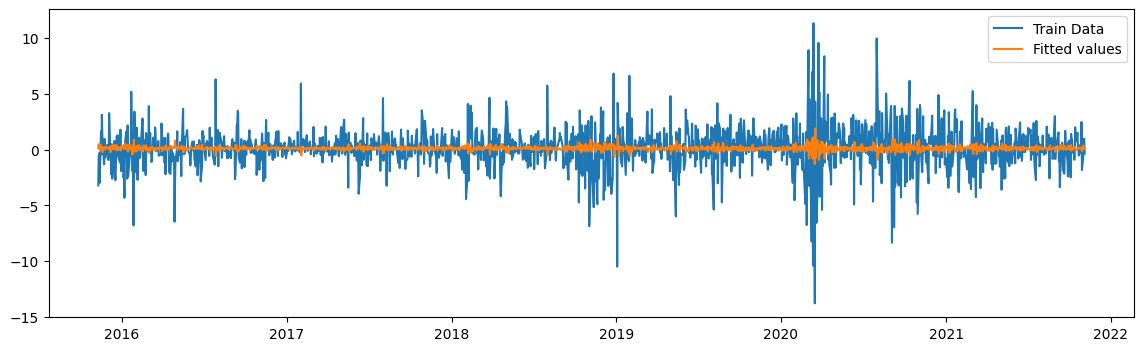

In [24]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train, label='Train Data')
ax.plot(arima_fit.fittedvalues, label='Fitted values')
plt.legend(loc = 'best')
plt.show()

In [ ]:
%%time
# --- Optimization via grid search for aic information critetion ---
# Define endogenous variable
endog = train['Close']  # use training log returns

def objfunc(p, q, endog):
    fit = ARIMA(endog, order=(int(p), 0, int(q))).fit()
    return fit.aic

# Search p and q from 0 to 5 (inclusive)
grid = (slice(0, 5), slice(0, 5))  # ARIMA(p, q), searches each parameter from 0 to 5. The first one belongs to ar and the second one to ma

# Use a lambda to pass each parameter separately
result = brute(lambda params: objfunc(params[0], params[1], endog), grid, finish=None)
print("Best order:", result)

c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\

Best order: [3. 4.]
CPU times: total: 23.9 s
Wall time: 26.3 s


c:\Users\ncesc\Documents\python_dev\Personal_portfolio\03_Time_series\.ts_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
